In [1]:
%reload_ext autoreload
%autoreload 3

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=False)
# mpl.rc('font', family='DejaVuSans', size=12)

import numpy as np
from IPython.display import display

import torch
import torchmetrics
import pytorch_lightning as pl
import pandas as pd
from src.cogponder import CogPonderModel
from src.cogponder.data import StroopSRODataset, CogPonderDataModule, NBackSRODataset
from pathlib import Path

from tqdm import tqdm

In [2]:
# Load checkpoint and data

ckpt_path = Path('models/checkpoints/stroop/cogponder_5subjects_1544epochs.ckpt')
model_ckpt = CogPonderModel.load_from_checkpoint(ckpt_path).to('cpu')

print('loading data module... ', end='')
dataset = StroopSRODataset(n_subjects=5,
                           step_duration=10,
                           shuffle_subjects=False,
                           non_decision_time='auto')
datamodule = CogPonderDataModule(dataset, num_workers=8)
datamodule.prepare_data()

subject_ids, trial_ids, contexts, stimuli, y_human, rt_human, y_correct = datamodule.test_dataset[:]
print('Done.')

human_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (y_human == y_correct).float() * 100,
    'agent': 'Human data',
})

loading data module... Done.


In [3]:

with torch.no_grad():
    model_ckpt.eval()

    rt_preds = []
    # we run 10 test runs to get a better estimate of the RT
    for i in tqdm(range(10)):
        y_pred, ctxt_preds, y_steps, p_halts, rt_pred = model_ckpt(stimuli, subject_ids)
        rt_preds.append(rt_pred.numpy())

    rt_preds = np.array(rt_preds)

rt_pred = rt_preds.mean(axis=0)

cogpo_stats = pd.DataFrame({
    'condition': dataset.inverse_transform_context(contexts),
    'subject': subject_ids,
    'response_time': (rt_pred * dataset.step_duration),
    'accuracy': (y_pred == y_correct).float() * 100,
    'agent': 'CogPonder agent',
})

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 10.86it/s]


In [4]:


stats = pd.concat([human_stats, cogpo_stats]).reset_index()

# mean_accuracy = stats.groupby(['agent', 'condition'])['accuracy'].mean()
# median_rt = stats.groupby(['agent', 'condition'])['response_time'].mean()
# median_rt, mean_accuracy

plot_data = stats.melt(
    id_vars=['condition', 'agent'],
    value_vars=['response_time', 'accuracy'],
    var_name='measure'
)

<Axes: xlabel='agent', ylabel='value'>

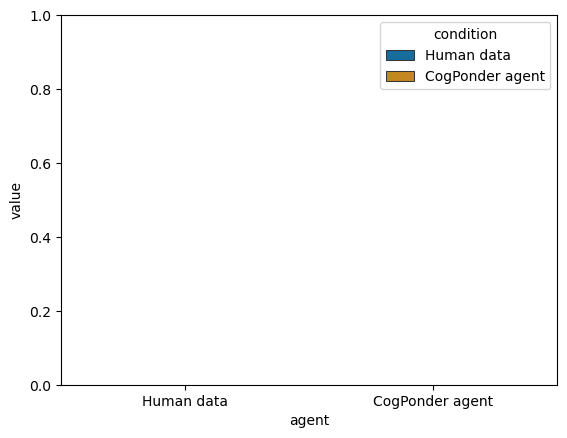

In [5]:
sns.boxplot(data=plot_data.query('measure == "response_time"'),
            x='agent', y='value', hue='condition',
            whis=10,
            hue_order=['Human data', 'CogPonder agent'], palette='colorblind')

/opt/conda/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


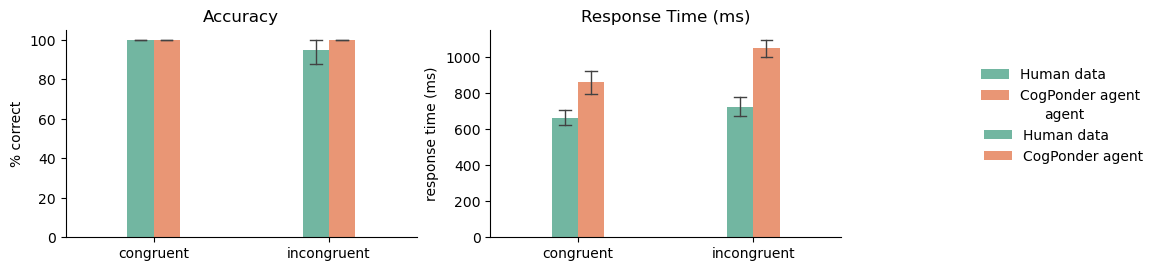

In [6]:

g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['congruent', 'incongruent'],
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('response time (ms)')
g.axes[0,1].set_title('Response Time (ms)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


# plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1.1)
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
human_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_human * dataset.step_duration,
    'accuracy': (y_human == y_correct).float(),
    'agent': 'Human data',
})

cogponder_performance = pd.DataFrame({
    'condition': contexts,
    'response_time': rt_pred * dataset.step_duration,
    'accuracy': (y_pred == y_correct).float(),
    'agent': 'CogPonder agent'
})

plot_data = pd.concat([human_performance, cogponder_performance]).reset_index()

plot_data['condition'] = plot_data['condition'].map({0: 'Incongruent', 1: 'Congruent'})

plot_data = plot_data.melt(id_vars=['condition', 'agent'],
               value_vars=['response_time', 'accuracy'],
               var_name='measure'
               )

/opt/conda/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_76635/1906628440.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


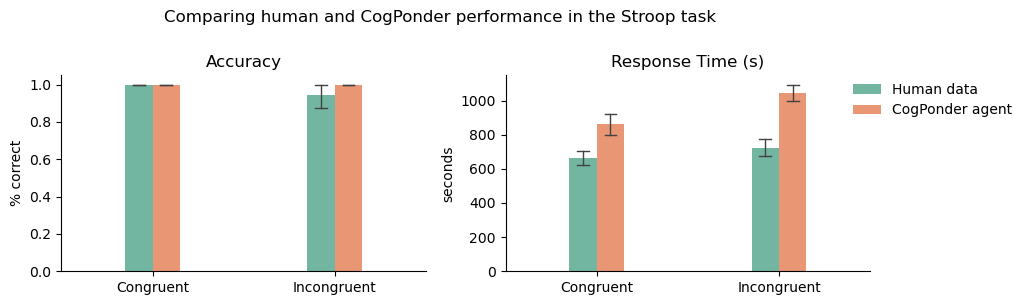

In [8]:
g = sns.catplot(
    data=plot_data, x='condition', y='value', col='measure', hue='agent',
    kind="bar", height=3, aspect=1.2,
    width=.3, errorbar=('ci', 95), capsize=.065, errwidth=1,
    palette='Set2',
    sharex=False, sharey=False,
    estimator='mean',
    col_order=['accuracy', 'response_time'],
    hue_order=['Human data', 'CogPonder agent'],
    order=['Congruent', 'Incongruent'],
    legend=False
)

g.add_legend(loc='upper left', bbox_to_anchor=(.95, .8))

g.axes[0,0].set_ylabel('% correct')
g.axes[0,0].set_title('Accuracy')
g.axes[0,1].set_ylabel('seconds')
g.axes[0,1].set_title('Response Time (s)')
g.axes[0,0].set_xlabel(None)
g.axes[0,1].set_xlabel(None)


plt.suptitle('Comparing human and CogPonder performance in the Stroop task', y=1)
plt.tight_layout()
plt.savefig('outputs/figures/figure3-stroop.png', bbox_inches='tight', dpi=300)
plt.show()

/opt/conda/envs/cogponder/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


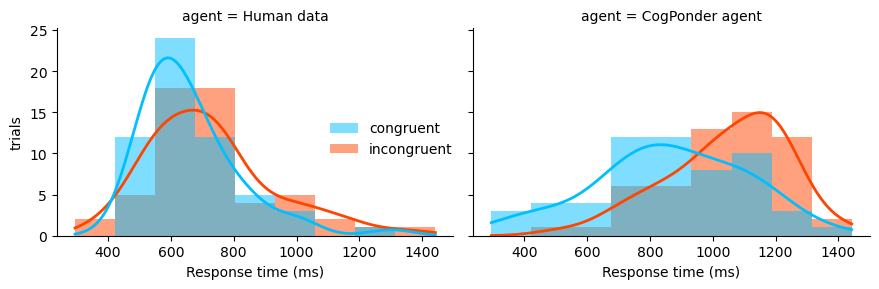

In [9]:
# Figure 4

plot_data = stats[['condition', 'agent', 'response_time', 'accuracy']]

g = sns.displot(
    data=plot_data, x='response_time', hue='condition', col='agent',
    kind='hist', kde=True, fill=True, common_norm=True,
    lw=0, alpha=.5, height=3, aspect=1.5,
    kde_kws={'cut': 0, 'clip': (0, 2000)},
    line_kws={'linewidth': 2},
    palette=sns.color_palette(['deepskyblue', 'orangered'], 2),
)

g.set(xlabel='Response time (ms)', ylabel='trials')
g.legend.set_title(None)
g.legend.set_bbox_to_anchor((.45, .5))

# plt.suptitle('Comparing human (N=1) and CogPonder response time distributions in the Stroop task')
# plt.tight_layout()
plt.savefig('outputs/figures/figure4-stroop.png', bbox_inches='tight', dpi=300)

<Axes: xlabel='median', ylabel='mean'>

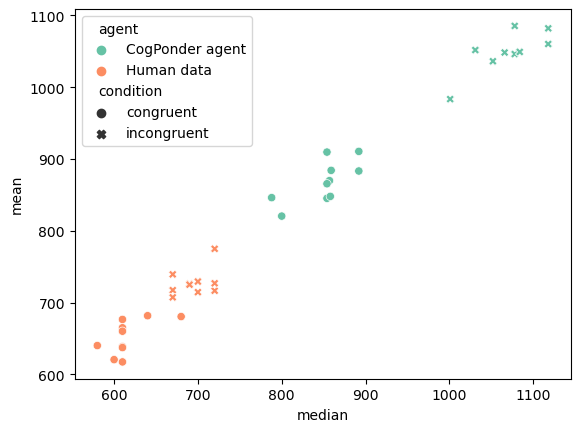

In [10]:

# sns.relplot(
#     data=plot_data, x='response_time', y='response_time', hue='condition',
#     style='agent',
# )


def boot_ci(x):

    res = []
    for _ in range(10):
        x_sample = x.sample(25)
        mean = x_sample.mean().item()
        medi = x_sample.median().item()
        sd = x_sample.std().item()
        res.append([mean, medi, sd])
    return res
    # return torchmetrics.functional.bootstrapped_ci(x, alpha=.05, num_samples=1000)

xx = plot_data.query('response_time < 1500').groupby(['condition', 'agent'])['response_time'].apply(boot_ci).apply(pd.Series)
xx = xx.reset_index().melt(id_vars=['condition', 'agent'])
xx[['mean','median', 'sd']] = xx['value'].apply(pd.Series)

sns.scatterplot(data=xx, x='median', y='mean', hue='agent', style='condition', palette='Set2')
# sns.histplot(data=xx, x='mean', y='median', bins=50, pthresh=.1, cmap="mako")
# sns.kdeplot(data=xx, x='mean', y='median', hue='condition', levels=2, linewidths=1)

In [11]:
# sns.scatterplot(data=plot_data, x='accuracy', y='response_time', hue='agent', style='condition', palette='Set2')
plot_data.shape

(226, 4)